<a href="https://colab.research.google.com/github/tkusak27/nfl-spreads-ai/blob/main/nfl_spreads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [18]:
# imports
import os, sys, requests
import tqdm
import tqdm, csv
import pandas as pd
import numpy as np
import gspread
from google.colab import auth
auth.authenticate_user()
from google.auth import default
from collections import defaultdict

# Reading spreadsheet


In [20]:
# reading spreadsheet

# Authenticate Google Credentials
creds, _ = default()
gc = gspread.authorize(creds)

# Open worksheet and record in Pandas DF
worksheet = gc.open('nfl-spreads').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])


# Effective Dictionary
- Creating a dictionary to store more detailed information about a team to be tested during regression

In [21]:
teams = defaultdict(dict)


for index, row in df.iterrows():
  # Data
  week = int(row['week'])
  home_spread = float(row['home_spread'])
  home_ml = float(row['home_ml'])
  away_ml = float(row['away_ml'])
  ou = float(row['ou'])
  home_score = int(row['home_score'])
  away_score = int(row['away_score'])

  #
  team = {}




"\nfor index, row in df.iterrows():\n  week = int(row['week'])\n  home_spread = float(row['home_spread'])\n  home_ml = float(row['home_ml'])\n  away_ml = float(row['away_ml'])\n  ou = float(row['ou'])\n\n  home_score = int(row['home_score'])\n  away_score = int(row['away_score'])\n"

# Spread Analysis

In [22]:
# analyzing spreads
games = 0

# Home favorites
hfws = 0
hfls = 0
hf_comp_ml = 0
hfg = 0
# spreads
hsfg = 0
hsfc = 0
hsf_comp = 0

# Away favorites
afws = 0
afls = 0
af_comp_ml = 0
afg = 0
# spreads
asfg = 0
asfc = 0
asf_comp = 0

for index, row in df.iterrows():
  games += 1

  home_spread = float(row['home_spread'])
  away_spread = float(row['away_spread'])

  home_ml = int(row['home_ml'])
  away_ml = int(row['away_ml'])

  home_score = int(row['home_score'])
  away_score = int(row['away_score'])

  # if home is the favorite
  if home_ml <= away_ml:
    hfg += 1
    hf_comp_ml += home_ml
    # home wins
    if home_score > away_score:
      hfws += 1
    else:
      hfls += 1
  # away is the favorite
  else:
    afg += 1
    af_comp_ml += away_ml
    # home wins
    if home_score > away_score:
      afls += 1
    else:
      afws += 1

  if home_spread <= away_spread:
    hsfg += 1
    hsf_comp += home_spread
    if home_score + home_spread > away_score:
       hsfc += 1
  else:
    asfg += 1
    asf_comp += away_spread
    if away_score + away_spread > home_score:
      asfc += 1


print(f"Home favorites win {100 * (hfws / hfg):.2f}% of the time and on average odds are {(hf_comp_ml / hfg):.2f}")
print(f"Away favorites win {100 * (afws / afg):.2f}% of the time and on average odds are {(af_comp_ml / afg):.2f}" )

print(f"Home spread favorites cover {100 * (hsfc / hsfg):.2f}% of the time and on average odds are {(hsf_comp / hsfg):.2f}")
print(f"Away spread favorites cover {100 * (asfc / asfg):.2f}% of the time and on average odds are {(asf_comp / asfg):.2f}")

Home favorites win 68.18% of the time and on average odds are -310.89
Away favorites win 65.00% of the time and on average odds are -195.33
Home spread favorites cover 54.65% of the time and on average odds are -5.43
Away spread favorites cover 48.39% of the time and on average odds are -3.52


# Clustering


- CONTINUE - need to run clustering data more accurately based on the different weeks and outcomes

100%|██████████| 7/7 [00:00<00:00, 56.95it/s]

(0.0, 1.0, 0.0)
(0.1837543827980445, 0.898368429205393, 0.3051024050186299)
(0.25462651396459807, 0.8886095857947977, 0.39582997974622025)
(0.27537266065092203, 0.6752732797925045, 0.39121147382420773)
(0.34109123334562125, 0.7217426461538778, 0.4632522430517318)
(0.3577003252559662, 0.7413568991297954, 0.48256559907094454)
(0.39379933871308276, 0.7278299187433731, 0.5110760775743481)


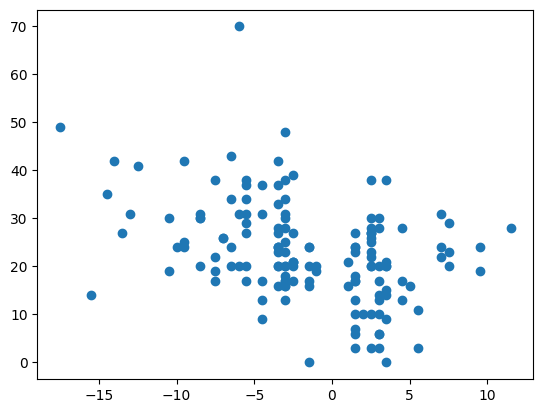

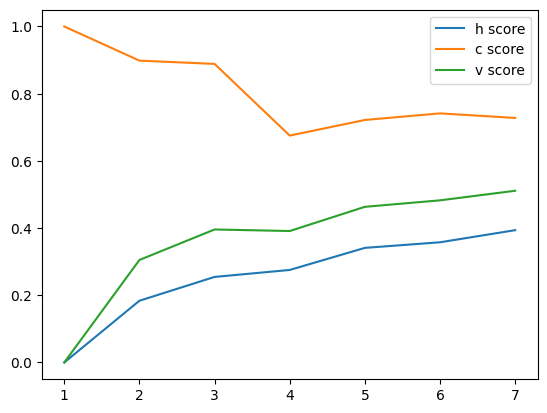

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import numpy as np
import tqdm

exps = {}

data = [[float(row['home_spread']), int(row['home_score'])] for index, row in df.iterrows()]

for k in tqdm.tqdm(range(1,8)):
  exps[k] = {}
  kmeans = KMeans(n_clusters=k, n_init='auto').fit(data)
  hcv = homogeneity_completeness_v_measure(df['home_score'],kmeans.labels_)
  print( hcv)
  exps[k]['h'],exps[k]['c'],exps[k]['v'] = hcv


import matplotlib.pyplot as plt

plt.scatter([i[0] for i in data], [i[1] for i in data])
plt.show()


krange = range(1,8)
plt.plot(krange,[exps[k]['h'] for k in krange],label='h score')
plt.plot(krange,[exps[k]['c'] for k in krange],label='c score')
plt.plot(krange,[exps[k]['v'] for k in krange],label='v score')
plt.legend()
plt.show()

# Spreads - Linear Regression Testing

In [85]:
# Want to test data vs labels
# Data: home spread
# Label: Cover vs no cover
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.base import clone

MY_RANDOM_STATE = 26

tags =        ["LR", "LDA", "DTC"]

results = defaultdict(list)

for i in range(2, 11):
  last_week = i
  xtrain = []
  ytrain = []
  xtest = []
  test_tags = []
  actual = []

  for index, row in df.iterrows():
    week = int(row['week'])
    home_spread = float(row['home_spread'])
    home_ml = float(row['home_ml'])
    away_ml = float(row['away_ml'])
    ou = float(row['ou'])

    home_score = int(row['home_score'])
    away_score = int(row['away_score'])

    appender = [home_spread, home_ml, ou, week]

    # which week we want to test
    if week == last_week:
      xtest.append(appender)
      test_tags.append(int(row['game_id']))
      if home_score + home_spread > away_score:
        actual.append("HC")
      elif home_score + home_spread < away_score:
        actual.append("AC")
      else:
        actual.append("PU")
    # collect training data of all weeks except that one
    elif week in set(i for i in range(1,last_week)):
      xtrain.append(appender)
      if home_score + home_spread > away_score:
        ytrain.append("HC")
      elif home_score + home_spread < away_score:
        ytrain.append("AC")
      else:
        ytrain.append("PU")


  classifiers =   [ LogisticRegression(random_state=MY_RANDOM_STATE,max_iter=1000),
                    LinearDiscriminantAnalysis(),
                    DecisionTreeClassifier(random_state=MY_RANDOM_STATE)]

  for (tag, classifier) in zip(tags, classifiers):
    classifier.fit(xtrain, ytrain)
    prediction = classifier.predict(xtest)
    accuracy = accuracy_score(actual, prediction)
    results[tag].append(accuracy)


for key, value in results.items():
  print(f"{key}: {value}")

LR: [0.4375, 0.4666666666666667, 0.5, 0.42857142857142855, 0.7142857142857143, 0.6153846153846154, 0.5625, 0.5714285714285714, 0.42857142857142855]
LDA: [0.4375, 0.4666666666666667, 0.5, 0.42857142857142855, 0.7857142857142857, 0.6153846153846154, 0.5625, 0.5714285714285714, 0.42857142857142855]
DTC: [0.375, 0.4, 0.75, 0.2857142857142857, 0.5, 0.6923076923076923, 0.625, 0.5, 0.5714285714285714]


# Over-under analysis


In [88]:
weeks   = []
ous     = []
hits    = []

totals = defaultdict(list)

# grab totals data
for index, row in df.iterrows():
  week = int(row['week'])
  id = int(row['game_id'])
  total = float(row['total'])
  ou = float(row['ou'])

  if week not in totals:
    totals[week] = []

  if total > ou:
    totals[week].append((id, 1, total - ou, ou))
  elif total == ou:
    totals[week].append((id, 0, total - ou, ou))
  else:
    totals[week].append((id, -1, total - ou, ou))


winners, differences = [], []
weekly_averages = []
for key, value in totals.items():
  winners.append(sum(tup[1] for tup in value))
  differences.append(sum(tup[2] for tup in value))
  weekly_averages.append(sum(tup[3] for tup in value)/len(value))

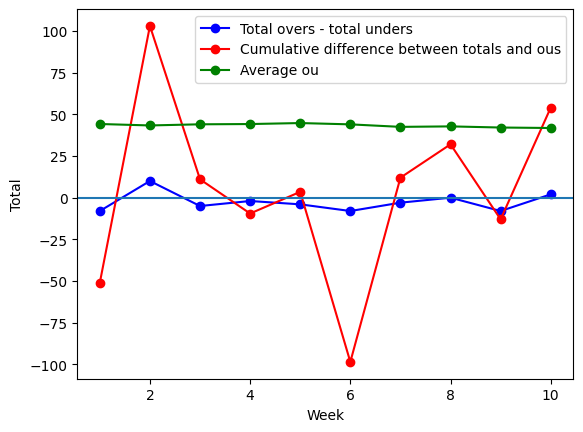

In [26]:

plt.plot(totals.keys(), winners, color = 'blue', marker='o', label='Total overs - total unders')
plt.plot(totals.keys(), differences, color = 'red', marker ='o', label='Cumulative difference between totals and ous')
plt.plot(totals.keys(), weekly_averages, color = 'green', marker ='o', label='Average ou')
plt.xlabel('Week')
plt.ylabel('Total')
plt.legend()
plt.axhline()
plt.show()

Over Under - Linear Regression Testing

In [87]:
MY_RANDOM_STATE = 26

tags =        ["LR", "LDA", "DTC"]

results = defaultdict(list)

for i in range(2, 11):
  last_week = i
  xtrain = []
  ytrain = []
  xtest = []
  test_tags = []
  actual = []

  for index, row in df.iterrows():
    week = int(row['week'])
    home_spread = float(row['home_spread'])
    home_ml = float(row['home_ml'])
    away_ml = float(row['away_ml'])
    ou = float(row['ou'])

    home_score = int(row['home_score'])
    away_score = int(row['away_score'])

    total = home_score + away_score

    appender = [home_spread, home_ml, ou, week]

    # which week we want to test
    if week == last_week:
      xtest.append(appender)
      test_tags.append(int(row['game_id']))
      if total > ou:
        actual.append("O")
      elif total < ou:
        actual.append("U")
      else:
        actual.append("P")
    # collect training data of all weeks except that one
    elif week in set(i for i in range(1,last_week)):
      xtrain.append(appender)
      if total > ou:
        ytrain.append("O")
      elif total < ou:
        ytrain.append("U")
      else:
        ytrain.append("P")


  classifiers =   [ LogisticRegression(random_state=MY_RANDOM_STATE,max_iter=1000),
                    LinearDiscriminantAnalysis(),
                    DecisionTreeClassifier(random_state=MY_RANDOM_STATE)]

  for (tag, classifier) in zip(tags, classifiers):
    classifier.fit(xtrain, ytrain)
    prediction = classifier.predict(xtest)
    accuracy = accuracy_score(actual, prediction)
    results[tag].append(accuracy)


for key, value in results.items():
  print(f"{key}: {value}")

LR: [0.1875, 0.3333333333333333, 0.4375, 0.5714285714285714, 0.7857142857142857, 0.6153846153846154, 0.5, 0.7857142857142857, 0.5]
LDA: [0.1875, 0.3333333333333333, 0.4375, 0.5714285714285714, 0.7857142857142857, 0.6153846153846154, 0.5, 0.7857142857142857, 0.5]
DTC: [0.4375, 0.3333333333333333, 0.4375, 0.6428571428571429, 0.5714285714285714, 0.5384615384615384, 0.5, 0.35714285714285715, 0.42857142857142855]
